In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ast
from configparser import ConfigParser

In [2]:
config = ConfigParser()
config.read("config.ini") 

csvf_aligned = config['CORPORA']['ALIGNED_CONFL_RST']
csvf_aligned_parasubtrees = config['OUTPUT']['ALIGNED_CONFL_RST_PARASUBTREES']

In [3]:
df = pd.read_csv(csvf_aligned_parasubtrees, index_col=0)
df = df.replace("_", "No_Conflict")

In [4]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [5]:
def conflicts_to_binary(df):
    df = df.replace("_", "No_Conflict")
    df = df.replace("Indirect_NegEval", "Conflict")
    df = df.replace("Direct_NegEval", "Conflict")
    df = df.replace("Challenge", "Conflict")
    df = df.replace("Correction", "Conflict")
    return df

In [6]:
def drop_relations(table):
    table = table.drop("span")
    table = table.drop("sameunit")
    table = table.drop("textual-organization")
    table = table.drop("topic-comment")
    table = table.drop("unless")
    table = table.drop("otherwise")
    table = table.drop("solutionhood")
    
    # merge some relations
    table.loc['reason-N'] += table.loc['reason-S']
    table.loc['evaluation-N'] += table.loc['evaluation-S']
    table = table.drop('reason-S')
    table = table.drop('evaluation-S')
    table = table.rename({'reason-N': "reason", 'evaluation-N': "evaluation"})
    return table

In [7]:
# list to reindex based on rst relations groups 
index_list = [ 'attribution',
                # pragmatic
                'background', 'enablement', 'evaluation', 'evidence', 'motivation', 'reason', 
                #contrastive
                'antithesis', 'concession', 'contrast',
                # sematic
                'cause', 'circumstance', 'condition', 'e-elaboration', 'elaboration', 'interpretation',
                'means', 'purpose', 'result',
                # textual
                'preparation', 'restatement', 'summary',
                # enumerating
                'list',  'conjunction',  'joint', 'sequence']

In [10]:
def table_2_crosstable(dataframe):
    # Compute a frequency table of two columns (crosstab), here: Conflict Type and RST leaf note relation
    crosstb = pd.crosstab(dataframe['Conflict_Type'], df['rstree_relation_leave'])
    crosstb['sum'] = crosstb.sum(axis=1) # create a sum of appearances
    crosstb_new = crosstb.loc[:, "antithesis":"unless"].div(crosstb["sum"], axis=0) # divide appearances with sum
    crosstb_new_perc = crosstb_new *100 # to percent
     # for table 
    crosstb_new_perc = crosstb_new_perc.transpose() # transpose table (swap rows and columns)
    return crosstb_new_perc

### 1. Count RST relations on leaf notes for all Conflict types

#### Table Preperation

In [11]:
# Compute a frequency table of two columns (crosstab), here: Conflict Type and RST leaf note relation
crosstb1  = table_2_crosstable(df)

In [12]:
# drop and merge some relations
crosstb1 = drop_relations(crosstb1)

In [13]:
# reindex based on rst relations group (attribution, pragmatic, contrastive, semantic, textual, enumerating)
counts1 = crosstb1.reindex(index_list)

#### plotting table

In [14]:
from pathlib import Path
csv_rst_confl_path = Path(r"../data/output/rst_distribution_conflicts.csv")


In [15]:
counts1_round = counts1.round(2)

counts1_round.to_csv(csv_rst_confl_path)

In [16]:
counts1_round

Conflict_Type,Challenge,Correction,Direct_NegEval,Indirect_NegEval,No_Conflict
rstree_relation_leave,,,,,
attribution,18.29,6.29,2.84,3.85,5.13
background,1.22,0.00,0.39,0.00,1.30
enablement,0.00,0.00,0.26,0.00,0.14
evaluation,0.00,0.70,2.06,0.68,1.52
evidence,1.22,0.70,0.52,1.13,0.93
motivation,0.00,0.00,0.00,0.00,0.23
reason,0.00,0.00,1.42,0.91,1.41
antithesis,4.88,3.50,0.77,0.91,0.82
concession,1.22,0.70,2.19,1.36,1.49


#### plotting barchart

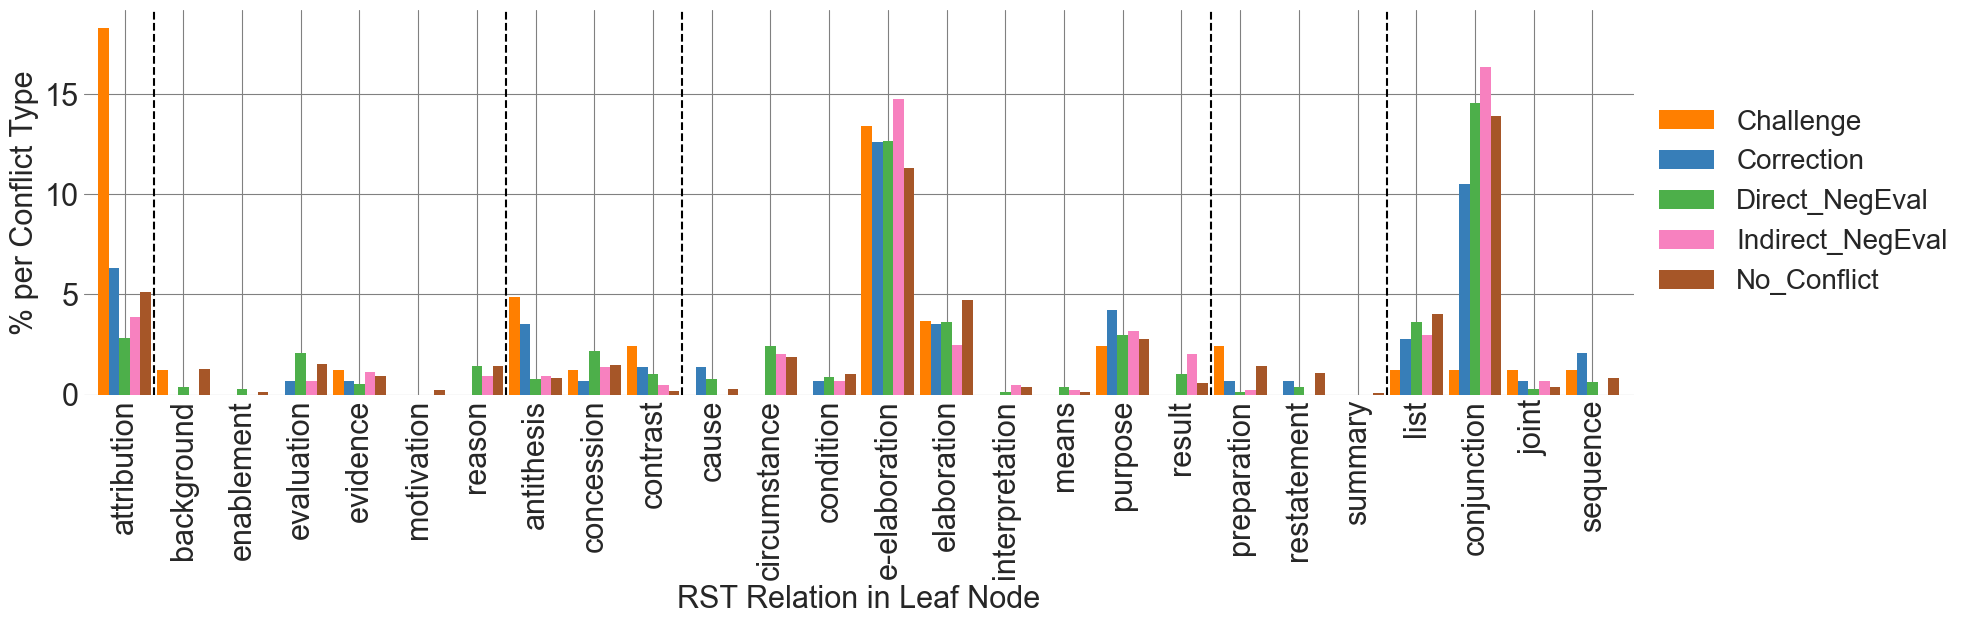

In [17]:
#%matplotlib notebook
%matplotlib inline

plt.style.use('seaborn-v0_8-dark')
plt.rcParams["figure.figsize"] = (20,5)
plt.rc('font', size=22)
plt.rc('xtick', labelsize=22)
plt.rcParams['grid.color'] = 'grey'
colors= {'Correction': '#377eb8', 'Challenge': '#ff7f00', 'Direct_NegEval': '#4daf4a', 'Indirect_NegEval': '#f781bf', 'No_Conflict': '#a65628'}
ax = counts1.plot.bar(width = 0.9, color=colors)

plt.axvline([0.5], color= "black", linestyle="dashed")
plt.axvline([6.5], color= "black", linestyle="dashed")
plt.axvline([9.5], color= "black", linestyle="dashed")
plt.axvline([18.5], color= "black", linestyle="dashed")
plt.axvline([21.5], color= "black", linestyle="dashed")

ax.set_axisbelow(True)
ax.set_facecolor("white")


ax.grid()
plt.xlabel("RST Relation in Leaf Node")
plt.ylabel("% per Conflict Type")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)

#plt.savefig("../data/output/img/rst_barchart_conflicttypes.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [18]:
counts1_sm = counts1.loc[['attribution',
               'background', 'enablement', 'evaluation', 'evidence', 'motivation', 'reason',
               'antithesis', 'concession', 'contrast']]


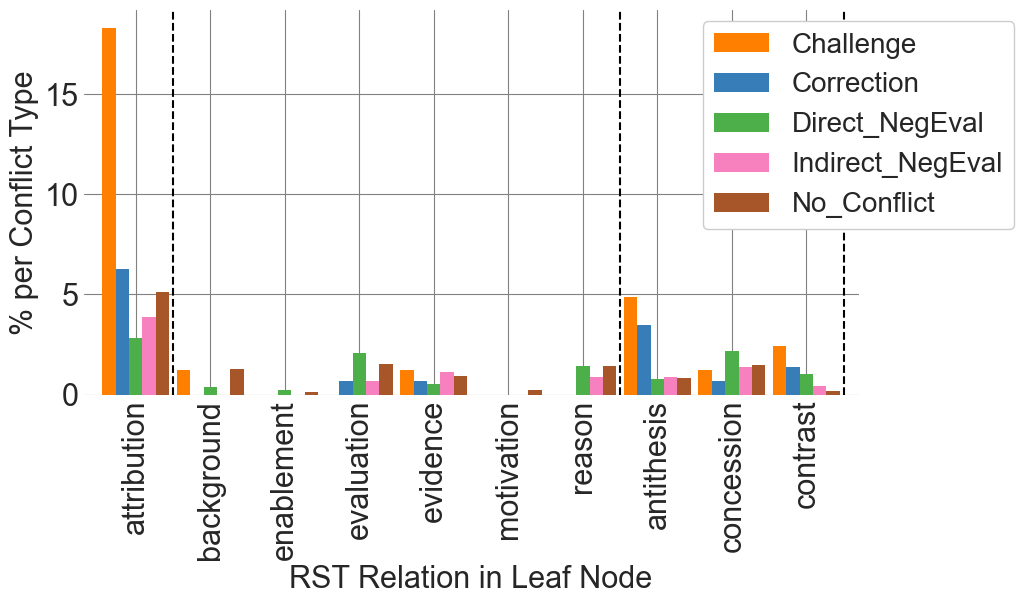

In [19]:
#%matplotlib notebook
%matplotlib inline

plt.style.use('seaborn-v0_8-dark')
plt.rcParams["figure.figsize"] = (10,5)
plt.rc('font', size=22)
plt.rc('xtick', labelsize=22)
plt.rcParams['grid.color'] = 'grey'
colors= {'Correction': '#377eb8', 'Challenge': '#ff7f00', 'Direct_NegEval': '#4daf4a', 'Indirect_NegEval': '#f781bf', 'No_Conflict': '#a65628'}
ax = counts1_sm.plot.bar(width = 0.9, color=colors)

plt.axvline([0.5], color= "black", linestyle="dashed")
plt.axvline([6.5], color= "black", linestyle="dashed")
plt.axvline([9.5], color= "black", linestyle="dashed")
plt.axvline([18.5], color= "black", linestyle="dashed")
plt.axvline([21.5], color= "black", linestyle="dashed")

ax.set_axisbelow(True)
ax.set_facecolor("white")


ax.grid()
plt.xlabel("RST Relation in Leaf Node")
plt.ylabel("% per Conflict Type")

matplotlib.rcParams['legend.frameon'] = 'True'
plt.legend(facecolor='white', framealpha=1, loc='center', bbox_to_anchor=(1.0, 0.7), fontsize=20)


#plt.savefig("../data/output/img/rst_barchart_conflicttypes_SM.pdf", format='pdf', bbox_inches='tight')
plt.show()

### (2) Count RST relations on leaf notes for Conflict YES / NO

#### Table preperation

In [20]:
df_b = conflicts_to_binary(df)

In [21]:
# Compute a frequency table of two columns (crosstab), here: Conflict Type and RST leaf note relation
binary_crosst = table_2_crosstable(df_b)
# drop and merge some relations
binary_crosst_perc = drop_relations(binary_crosst)
# reindex based on rst relations group (attribution, pragmatic, contrastive, semantic, textual, enumerating)
binary_crosst_perc = binary_crosst_perc.reindex(index_list)

In [22]:
binary_crosst_perc

Conflict_Type,Conflict,No_Conflict
rstree_relation_leave,,
attribution,4.368932,5.126761
background,0.277393,1.295775
enablement,0.138696,0.140845
evaluation,1.386963,1.521127
evidence,0.762829,0.929577
motivation,0.000000,0.225352
reason,1.040222,1.408451
antithesis,1.317614,0.816901
concession,1.733703,1.492958


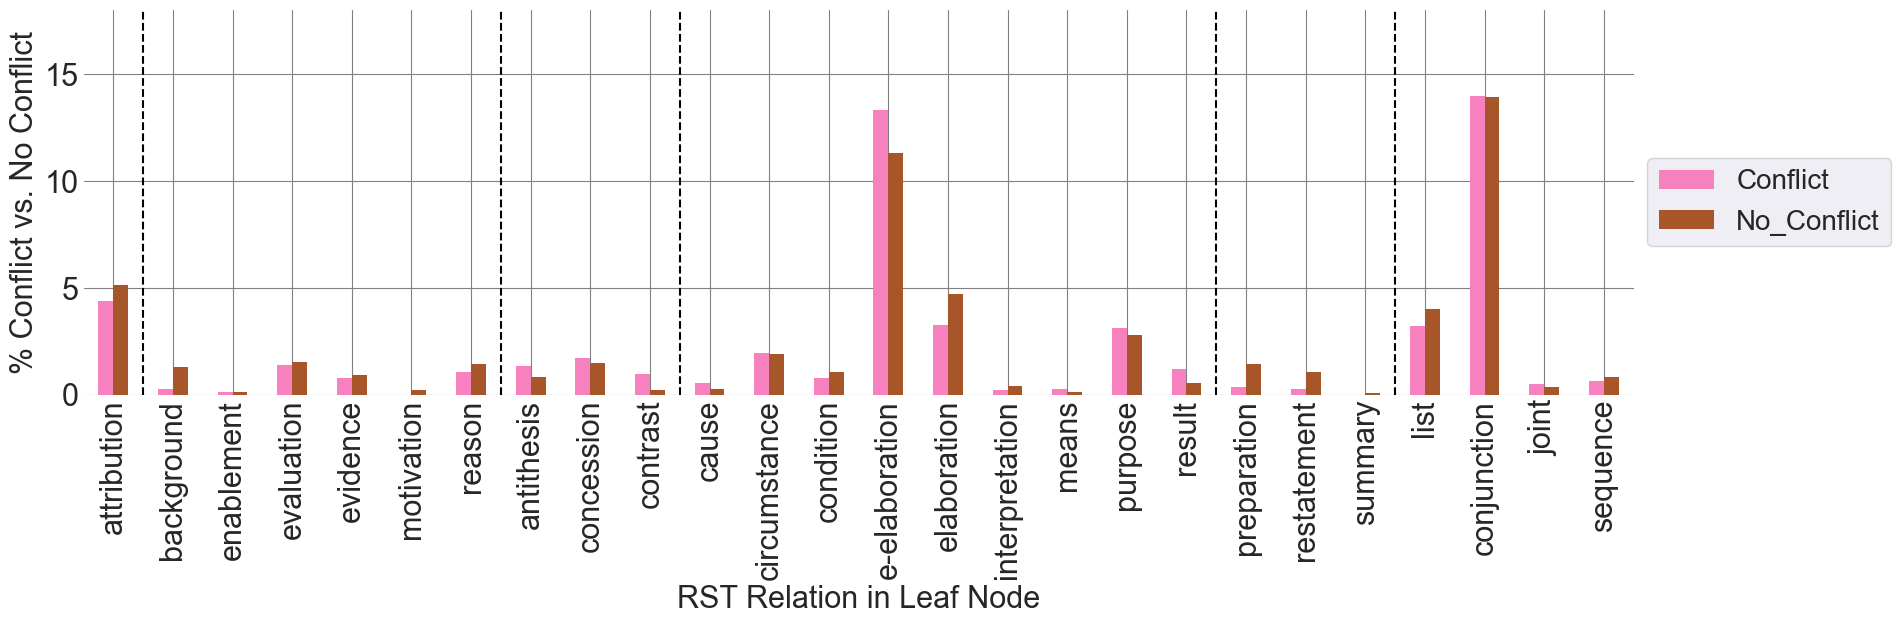

In [23]:
plt.style.use('seaborn-v0_8-dark')
plt.rcParams["figure.figsize"] = (20,5)
plt.rc('font', size=22)
plt.rc('xtick', labelsize=22)
plt.rcParams['grid.color'] = 'grey'
colors= {'Conflict': '#f781bf', 'No_Conflict': '#a65628'}

ax = binary_crosst_perc.plot.bar(color=colors)

plt.axvline([0.5], color= "black", linestyle="dashed")
plt.axvline([6.5], color= "black", linestyle="dashed")
plt.axvline([9.5], color= "black", linestyle="dashed")
plt.axvline([18.5], color= "black", linestyle="dashed")
plt.axvline([21.5], color= "black", linestyle="dashed")

ax.set_axisbelow(True)
ax.grid()
ax.set_facecolor("white")
ax.set_ylim(ymin=0, ymax=18)
plt.xlabel("RST Relation in Leaf Node")
plt.ylabel("% Conflict vs. No Conflict")

matplotlib.rcParams['legend.frameon'] = 'True'
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)

#plt.savefig("../data/output/img/rst_barchart_binary.pdf", format='pdf', bbox_inches='tight')
plt.show()

### (3) Count RST relations in paragraphs for Conflict Types
counts proportion of relations in paragraohs including at least one conflict-EDU comparing all conflict types,
counting all relations in a paragraph

In [ ]:
# preparing counts dataframe
para_idxs = df['paragraph_id_consecutive'].drop_duplicates().tolist()
dconfl_para_list_big = []
iconfl_para_list_big = []
chalconfl_para_list_big = []
corrconfl_para_list_big = []
noconfl_para_list_big = []

In [ ]:
for p_idx in para_idxs:
    df_para = df[df['paragraph_id_consecutive'] == p_idx]
    # Check if "Conflict" Exists in Column/paragraph
    if (df_para['Conflict_Type'].eq("Direct_NegEval")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            dconfl_para_list_big.append(y)
    elif (df_para['Conflict_Type'].eq("Indirect_NegEval")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            iconfl_para_list_big.append(y)
    elif (df_para['Conflict_Type'].eq("Challenge")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            chalconfl_para_list_big.append(y)
    elif (df_para['Conflict_Type'].eq("Correction")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            corrconfl_para_list_big.append(y)
    elif (df_para['Conflict_Type'].eq("No_Conflict")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            noconfl_para_list_big.append(y)

In [ ]:
dconfl_para_list_big = flatten_comprehension(dconfl_para_list_big)
iconfl_para_list_big = flatten_comprehension(iconfl_para_list_big)
chalconfl_para_list_big = flatten_comprehension(chalconfl_para_list_big)
corrconfl_para_list_big = flatten_comprehension(corrconfl_para_list_big)
noconfl_para_list_big = flatten_comprehension(noconfl_para_list_big)

In [ ]:
# write lists to dataframes
df_dconfl = pd.DataFrame(dconfl_para_list_big, columns=['Direct_NegEval'])
df_iconfl = pd.DataFrame(iconfl_para_list_big, columns=['Indirect_NegEval'])
df_chalconfl = pd.DataFrame(chalconfl_para_list_big, columns=['Challenge'])
df_corrconfl = pd.DataFrame(corrconfl_para_list_big, columns=['Correction'])
df_noconfl = pd.DataFrame(noconfl_para_list_big, columns=['No_Conflict'])

In [ ]:
counts_dconfl = df_dconfl['Direct_NegEval'].value_counts()
counts_iconfl = df_iconfl['Indirect_NegEval'].value_counts()
counts_chalconfl = df_chalconfl['Challenge'].value_counts()
counts_corrconfl = df_corrconfl['Correction'].value_counts()
counts_noconfl = df_noconfl['No_Conflict'].value_counts()

In [ ]:
counts3 = pd.concat([counts_chalconfl, counts_corrconfl, counts_dconfl, counts_iconfl, counts_noconfl], axis=1)
# replace NaN Value with zero
counts3 = counts3.fillna(0)
counts3 = counts3.astype(int)

sum_series = counts3.sum()
sum_list = sum_series.tolist()
counts3 = counts3.sort_index()

In [ ]:
counts3.loc[len(counts3)] = sum_list
counts3 = counts3.rename({35: 'sum'})
# get proportion of labels distribution per conflic vs no-conflict paragraoh
counts3 = counts3.loc["antithesis":"unless", :].div(counts3.loc["sum"], axis=1)
counts3_perc = counts3 *100
counts3_perc = drop_relations(counts3_perc)

In [ ]:
# small table:
counts3_perc = counts3_perc.loc[['attribution',
               'background', 'enablement', 'evaluation', 'evidence', 'motivation', 'reason',
               'antithesis', 'concession', 'contrast']]

In [ ]:
counts3_perc

In [ ]:
#%matplotlib notebook
%matplotlib inline

plt.style.use('seaborn-v0_8-dark')
plt.rcParams["figure.figsize"] = (10,5)
plt.rc('font', size=22)
plt.rc('xtick', labelsize=22)
plt.rcParams['grid.color'] = 'grey'
colors= {'Correction': '#377eb8', 'Challenge': '#ff7f00', 'Direct_NegEval': '#4daf4a', 'Indirect_NegEval': '#f781bf', 'No_Conflict': '#a65628'}
ax = counts3_perc.plot.bar(width = 0.9, color=colors)

plt.axvline([0.5], color= "black", linestyle="dashed")
plt.axvline([6.5], color= "black", linestyle="dashed")
plt.axvline([9.5], color= "black", linestyle="dashed")
plt.axvline([18.5], color= "black", linestyle="dashed")
plt.axvline([21.5], color= "black", linestyle="dashed")

ax.set_axisbelow(True)
ax.set_facecolor("white")


ax.grid()
plt.ylim(0, 16)
plt.xlabel("RST Relation in Paragraph")
plt.ylabel("% per Conflict Type")

matplotlib.rcParams['legend.frameon'] = 'True'
plt.legend(facecolor='white', framealpha=1, loc='center', bbox_to_anchor=(1.0, 0.7), fontsize=20)

plt.show()
#plt.savefig("../data/output/img/rst_barchart_conflicttypes_para.pdf", format='pdf', bbox_inches='tight')

### (4) Count RST relations in paragraphs for Conflict YES / NO
counts proportion of relations in paragraohs including at least one conflict-EDU vs no conflicts at all,
counting all relations in a paragraph

In [ ]:
df = conflicts_to_binary(df)

In [ ]:
# preparing counts dataframe
para_idxs = df['paragraph_id_consecutive'].drop_duplicates().tolist()
confl_para_list_big = []
noconfl_para_list_big = []
for p_idx in para_idxs:
    df_para = df[df['paragraph_id_consecutive'] == p_idx]
    # Check if "Conflict" Exists in Column/paragraph
    if (df_para['Conflict_Type'].eq("Conflict")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            confl_para_list_big.append(y)
    elif (df_para['Conflict_Type'].eq("No_Conflict")).any():
        for index, row in df_para.iterrows():
            # get df['rstree_nodeid_chain'] row from str to lists
            y_str = row['rstree_relation_chain_subtree']
            y = ast.literal_eval(y_str)
            noconfl_para_list_big.append(y)

confl_para_list_big = flatten_comprehension(confl_para_list_big)
noconfl_para_list_big = flatten_comprehension(noconfl_para_list_big)
df_confl = pd.DataFrame(confl_para_list_big, columns=['Conflict_RST_labels'])
df_noconfl = pd.DataFrame(noconfl_para_list_big, columns=['NoConflict_RST_labels'])
counts_confl = df_confl['Conflict_RST_labels'].value_counts()
counts_noconfl = df_noconfl['NoConflict_RST_labels'].value_counts()
counts = pd.concat([counts_confl, counts_noconfl], axis=1)
# replace NaN Value with zero
counts = counts.fillna(0)
counts['NoConflict_RST_labels'] = counts['NoConflict_RST_labels'].astype(int)
counts = counts.rename(columns={"Conflict_RST_labels" : "Conflict", "NoConflict_RST_labels": "No_Conflict"})



In [ ]:
sum_series = counts.sum()
sum_list = sum_series.tolist()
counts = counts.sort_index()

counts.loc[len(counts)] = sum_list
counts = counts.rename({35: 'sum'})

# get proportion of labels distribution per conflic vs no-conflict paragraoh
counts_new = counts.loc["antithesis":"unless", :].div(counts.loc["sum"], axis=1)
counts_new_perc = counts_new *100

In [ ]:
counts_new_perc = counts_new_perc.drop("span")
counts_new_perc = counts_new_perc.drop("sameunit")
counts_new_perc = counts_new_perc.drop("summary")
counts_new_perc = counts_new_perc.drop("textual-organization")
counts_new_perc = counts_new_perc.drop("topic-comment")
counts_new_perc = counts_new_perc.drop("unless")
counts_new_perc = counts_new_perc.drop("means")
counts_new_perc = counts_new_perc.drop("otherwise")
counts_new_perc = counts_new_perc.drop("solutionhood")

counts_new_perc.loc['reason-N'] += counts_new_perc.loc['reason-S']
counts_new_perc.loc['evaluation-N'] += counts_new_perc.loc['evaluation-S']
counts_new_perc = counts_new_perc.drop('reason-S')
counts_new_perc = counts_new_perc.drop('evaluation-S')
counts_new_perc.rename({'reason-N': "reason", 'evaluation-N': "evaluation"})

#### plot bar

In [ ]:
ax = counts_new_perc.plot.bar()
ax.set_axisbelow(True)
ax.grid()
plt.xlabel("RST Relation in Paragraph")
plt.ylabel("% Relation in Conflict vs. No Conflict")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=17)
plt.show()

